In [1]:
# Import necessary libraries
import sys

# Install required packages
!{sys.executable} -m pip install pandas numpy matplotlib seaborn statsmodels scikit-learn

# Import libraries after installation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt, atan2, degrees, pi
from scipy.stats import percentileofscore
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Specify the file path
file_path = "C:/Users/aasmi/OneDrive/Release_Angles/statcast_2023.csv"

# Read the CSV file into a DataFrame
statcast_2023 = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to ensure it has been read correctly
print(statcast_2023.head())




  pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
0         FF  2023-10-30           97.5          -1.18           6.04   
1         SL  2023-10-30           83.2          -1.61           5.70   
2         SL  2023-10-30           82.5          -1.69           5.83   
3         SI  2023-10-30           96.8          -1.35           6.01   
4         SL  2023-10-30           84.9          -1.62           5.81   

     player_name  batter  pitcher     events      description  ...  \
0  Leclerc, José  502054   600917  strikeout  swinging_strike  ...   
1  Leclerc, José  502054   600917        NaN             ball  ...   
2  Leclerc, José  502054   600917        NaN             foul  ...   
3  Leclerc, José  502054   600917        NaN    called_strike  ...   
4  Leclerc, José  572233   600917  strikeout  swinging_strike  ...   

   post_home_score  post_bat_score  post_fld_score  if_fielding_alignment  \
0                1               1               3             

In [2]:
# Drop rows with NaN values in specified columns
statcast_2023.dropna(subset=['vy0', 'release_extension', 'spin_axis'], inplace=True)

# Filter the DataFrame to only include rows where p_throws is 'R'
statcast_2023Right = statcast_2023[statcast_2023['p_throws'] == 'R']
statcast_2023Left = statcast_2023[statcast_2023['p_throws'] == 'L']

In [7]:
def calculate_vaa(row):
    yf = 17/12  # Home plate distance in feet, converted to inches
    ay = row['ay']  # Acceleration in y-dimension for the current pitch
    vy0 = row['vy0']  # Velocity in y-dimension at y=50 feet for the current pitch
    vz0 = row['vz0']  # Velocity in z-dimension at y=50 feet for the current pitch
    az = row['az']  # Acceleration in z-dimension for the current pitch

    vy_f = -sqrt(vy0**2 - (2 * ay * (50 - yf)))
    t = (vy_f - vy0) / ay
    vz_f = vz0 + (az * t)
    vaa_rad = atan2(vz_f, vy_f)
    vaa_deg = (180+degrees(vaa_rad))*-1

    return vaa_deg

def calculate_VRA(vy0, ay, release_extension, vz0, az):
    vy_s = -np.sqrt(vy0**2 - 2 * ay * (60.5 - release_extension - 50))
    t_s = (vy_s - vy0) / ay
    vz_s = vz0 - az * t_s
    VRA = -np.arctan(vz_s / vy_s) * (180 / np.pi)
    return VRA

def calculate_HRA(vy0, ay, release_extension, vx0, ax):
    vy_s = -np.sqrt(vy0**2 - 2 * ay * (60.5 - release_extension - 50))
    t_s = (vy_s - vy0) / ay
    vx_s = vx0 - ax * t_s
    HRA = -np.arctan(vx_s / vy_s) * (180 / np.pi)
    return HRA


statcast_2023Right['VAA'] = statcast_2023Right.apply(calculate_vaa, axis=1)
statcast_2023Right['VRA'] = statcast_2023Right.apply(lambda x: calculate_VRA(x['vy0'], x['ay'], x['release_extension'], x['vz0'], x['az']), axis=1)
statcast_2023Right['HRA'] = statcast_2023Right.apply(lambda x: calculate_HRA(x['vy0'], x['ay'], x['release_extension'], x['vx0'], x['ax']), axis=1)

statcast_2023Left['VAA'] = statcast_2023Left.apply(calculate_vaa, axis=1)
statcast_2023Left['VRA'] = statcast_2023Left.apply(lambda x: calculate_VRA(x['vy0'], x['ay'], x['release_extension'], x['vz0'], x['az']), axis=1)
statcast_2023Left['HRA'] = statcast_2023Left.apply(lambda x: calculate_HRA(x['vy0'], x['ay'], x['release_extension'], x['vx0'], x['ax']), axis=1)

C:\Users\aasmi\AppData\Local\Temp\ipykernel_27524\389002375.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  statcast_2023Right['VAA'] = statcast_2023Right.apply(calculate_vaa, axis=1)
C:\Users\aasmi\AppData\Local\Temp\ipykernel_27524\389002375.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  statcast_2023Right['VRA'] = statcast_2023Right.apply(lambda x: calculate_VRA(x['vy0'], x['ay'], x['release_extension'], x['vz0'], x['az']), axis=1)
C:\Users\aasmi\AppData\Local\Temp\ipykernel_27524\389002375.py

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming statcast_2023 is your dataframe
features_z = ['VRA', 'release_pos_z','pfx_z']
target_z = 'plate_z'

X_v_r = statcast_2023Right[features_z]
y_v_r = statcast_2023Right[target_z]
X_v_l = statcast_2023Left[features_z]
y_v_l = statcast_2023Left[target_z]

# Split the data
X_train_v_r, X_test_v_r, y_train_v_r, y_test_v_r = train_test_split(X_v_r, y_v_r, test_size=0.2, random_state=42)
X_train_v_l, X_test_v_l, y_train_v_l, y_test_v_l = train_test_split(X_v_l, y_v_l, test_size=0.2, random_state=42)

# Initial Random Forest Regressor with limited depth to reduce overfitting
rf_regressor_v_r = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_regressor_v_r.fit(X_train_v_r, y_train_v_r)

rf_regressor_v_l = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_regressor_v_l.fit(X_train_v_l, y_train_v_l)

# Predict on training data
y_train_pred_v_r = rf_regressor_v_r.predict(X_train_v_r)
y_train_pred_v_l = rf_regressor_v_l.predict(X_train_v_l)

# Predict on testing data
y_test_pred_v_r = rf_regressor_v_r.predict(X_test_v_r)
y_test_pred_v_l = rf_regressor_v_l.predict(X_test_v_l)

# Evaluate on training data
mse_train_v_r = mean_squared_error(y_train_v_r, y_train_pred_v_r)
r2_train_v_r = r2_score(y_train_v_r, y_train_pred_v_r)
mse_train_v_l = mean_squared_error(y_train_v_l, y_train_pred_v_l)
r2_train_v_l = r2_score(y_train_v_l, y_train_pred_v_l)

# Evaluate on testing data
mse_test_v_r = mean_squared_error(y_test_v_r, y_test_pred_v_r)
r2_test_v_r = r2_score(y_test_v_r, y_test_pred_v_r)
mse_test_v_l = mean_squared_error(y_test_v_l, y_test_pred_v_l)
r2_test_v_l = r2_score(y_test_v_l, y_test_pred_v_l)

print(f'Training Mean Squared Error: {mse_train_v_r}')
print(f'Training R^2 Score: {r2_train_v_r}')
print(f'Testing Mean Squared Error: {mse_test_v_r}')
print(f'Testing R^2 Score: {r2_test_v_r}')

print(f'Training Mean Squared Error: {mse_train_v_l}')
print(f'Training R^2 Score: {r2_train_v_l}')
print(f'Testing Mean Squared Error: {mse_test_v_l}')
print(f'Testing R^2 Score: {r2_test_v_l}')


# Cross-Validation
cv_scores_v_r = cross_val_score(rf_regressor_v_r, X_v_r, y_v_r, cv=5, scoring='r2')
print(f'Cross-Validation R^2 Scores: {cv_scores_v_r}')
print(f'Average Cross-Validation R^2 Score: {np.mean(cv_scores_v_r)}')

cv_scores_v_l = cross_val_score(rf_regressor_v_l, X_v_l, y_v_l, cv=5, scoring='r2')
print(f'Cross-Validation R^2 Scores: {cv_scores_v_l}')
print(f'Average Cross-Validation R^2 Score: {np.mean(cv_scores_v_l)}')

# Feature Importance
feature_importances_v_r = rf_regressor_v_r.feature_importances_
features_df_v_r = pd.DataFrame({'Feature': features_z, 'Importance': feature_importances_v_r})

feature_importances_v_l = rf_regressor_v_l.feature_importances_
features_df_v_l = pd.DataFrame({'Feature': features_z, 'Importance': feature_importances_v_l})

# Sort features by importance
features_df_v_r = features_df_v_r.sort_values(by='Importance', ascending=False)
features_df_v_l = features_df_v_l.sort_values(by='Importance', ascending=False)

print(features_df_v_r)
print(features_df_v_l)

Training Mean Squared Error: 0.07658885291292229
Training R^2 Score: 0.9186156007482175
Testing Mean Squared Error: 0.08035933007697364
Testing R^2 Score: 0.9150120240411039
Training Mean Squared Error: 0.07416589926891601
Training R^2 Score: 0.9200212671941931
Testing Mean Squared Error: 0.0822561660842893
Testing R^2 Score: 0.9131506638890982
Cross-Validation R^2 Scores: [0.91569124 0.91025302 0.91439535 0.91466894 0.90752568]
Average Cross-Validation R^2 Score: 0.9125068445533341
Cross-Validation R^2 Scores: [0.9014758  0.9138822  0.91088942 0.91490804 0.90933986]
Average Cross-Validation R^2 Score: 0.9100990630292725
         Feature  Importance
0            VRA    0.537195
2          pfx_z    0.326843
1  release_pos_z    0.135962
         Feature  Importance
2          pfx_z    0.450053
0            VRA    0.422876
1  release_pos_z    0.127072


In [15]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming statcast_2023 is your dataframe
features_x = ['HRA','release_pos_x','pfx_x']
target_x = 'plate_x'

X_h_r = statcast_2023Right[features_x]
y_h_r = statcast_2023Right[target_x]
X_h_l = statcast_2023Left[features_x]
y_h_l = statcast_2023Left[target_x]

# Split the data
X_train_h_r, X_test_h_r, y_train_h_r, y_test_h_r = train_test_split(X_h_r, y_h_r, test_size=0.2, random_state=42)
X_train_h_l, X_test_h_l, y_train_h_l, y_test_h_l = train_test_split(X_h_l, y_h_l, test_size=0.2, random_state=42)

# Initial Random Forest Regressor with limited depth to reduce overfitting
rf_regressor_h_r = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_regressor_h_r.fit(X_train_h_r, y_train_h_r)
rf_regressor_h_l = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_regressor_h_l.fit(X_train_h_l, y_train_h_l)

# Predict on training data
y_train_pred_h_r = rf_regressor_h_r.predict(X_train_h_r)
y_train_pred_h_l = rf_regressor_h_l.predict(X_train_h_l)

# Predict on testing data
y_test_pred_h_r = rf_regressor_h_r.predict(X_test_h_r)
y_test_pred_h_l = rf_regressor_h_l.predict(X_test_h_l)

# Evaluate on training data
mse_train_h_r = mean_squared_error(y_train_h_r, y_train_pred_h_r)
r2_train_h_r = r2_score(y_train_h_r, y_train_pred_h_r)
mse_train_h_l = mean_squared_error(y_train_h_l, y_train_pred_h_l)
r2_train_h_l = r2_score(y_train_h_l, y_train_pred_h_l)

# Evaluate on testing data
mse_test_h_r = mean_squared_error(y_test_h_r, y_test_pred_h_r)
r2_test_h_r = r2_score(y_test_h_r, y_test_pred_h_r)
mse_test_h_l = mean_squared_error(y_test_h_l, y_test_pred_h_l)
r2_test_h_l = r2_score(y_test_h_l, y_test_pred_h_l)

print(f'Training Mean Squared Error: {mse_train_h_r}')
print(f'Training R^2 Score: {r2_train_h_r}')
print(f'Testing Mean Squared Error: {mse_test_h_r}')
print(f'Testing R^2 Score: {r2_test_h_r}')

print(f'Training Mean Squared Error: {mse_train_h_l}')
print(f'Training R^2 Score: {r2_train_h_l}')
print(f'Testing Mean Squared Error: {mse_test_h_l}')
print(f'Testing R^2 Score: {r2_test_h_l}')


# Cross-Validation
cv_scores_h_r = cross_val_score(rf_regressor_h_r, X_h_r, y_h_r, cv=5, scoring='r2')
print(f'Cross-Validation R^2 Scores: {cv_scores_h_r}')
print(f'Average Cross-Validation R^2 Score: {np.mean(cv_scores_h_r)}')

cv_scores_h_l = cross_val_score(rf_regressor_h_l, X_h_l, y_h_l, cv=5, scoring='r2')
print(f'Cross-Validation R^2 Scores: {cv_scores_h_l}')
print(f'Average Cross-Validation R^2 Score: {np.mean(cv_scores_h_l)}')

# Feature Importance
feature_importances_h_r = rf_regressor_h_r.feature_importances_
features_df_h_r = pd.DataFrame({'Feature': features_x, 'Importance': feature_importances_h_r})
feature_importances_h_l = rf_regressor_h_l.feature_importances_
features_df_h_l = pd.DataFrame({'Feature': features_x, 'Importance': feature_importances_h_l})

# Sort features by importance
features_df_h_r = features_df_h_r.sort_values(by='Importance', ascending=False)
features_df_h_l = features_df_h_l.sort_values(by='Importance', ascending=False)

print(features_df_h_l)
print(features_df_h_r)



Training Mean Squared Error: 0.01336922879412911
Training R^2 Score: 0.9808052307407897
Testing Mean Squared Error: 0.014537842286340995
Testing R^2 Score: 0.9791530285643611
Training Mean Squared Error: 0.010114236169265128
Training R^2 Score: 0.9850814910365222
Testing Mean Squared Error: 0.011976440453063036
Testing R^2 Score: 0.9822324868923841
Cross-Validation R^2 Scores: [0.98061139 0.98092879 0.97894936 0.97772955 0.97934016]
Average Cross-Validation R^2 Score: 0.9795118509052404
Cross-Validation R^2 Scores: [0.98139265 0.98145445 0.98343365 0.98117009 0.97716173]
Average Cross-Validation R^2 Score: 0.9809225123251574
         Feature  Importance
0            HRA    0.385331
2          pfx_x    0.330550
1  release_pos_x    0.284119
         Feature  Importance
0            HRA    0.401413
2          pfx_x    0.348866
1  release_pos_x    0.249721


In [19]:
# Filter to include only numeric columns
numeric_columns = statcast_2023Right.select_dtypes(include=[np.number])

# Compute correlation with 'HRA' and sort the values in descending order
correlation_results = numeric_columns.corr()['HRA'].sort_values(ascending=False)

# Display the top ten correlations
top_ten_correlations = correlation_results.head(11)  # Include top 11 because the list includes 'HRA' correlating with itself
print(top_ten_correlations.drop('HRA'))  # Exclude 'HRA' from the results to show only correlations with other variables

vx0                  0.992331
plate_x              0.452693
spin_axis            0.452547
release_speed        0.317126
effective_speed      0.315006
pfx_z                0.252462
az                   0.241315
ay                   0.223387
release_extension    0.126641
VAA                  0.124886
Name: HRA, dtype: float64


In [20]:
# Filter to include only numeric columns
numeric_columns = statcast_2023Left.select_dtypes(include=[np.number])

# Compute correlation with 'HRA' and sort the values in descending order
correlation_results = numeric_columns.corr()['HRA'].sort_values(ascending=False)

# Display the top ten correlations
top_ten_correlations = correlation_results.head(11)  # Include top 11 because the list includes 'HRA' correlating with itself
print(top_ten_correlations.drop('HRA'))  # Exclude 'HRA' from the results to show only correlations with other variables

vx0                  0.992272
spin_axis            0.448369
plate_x              0.425585
release_pos_z        0.314067
vy0                  0.304011
release_spin_rate    0.197155
VRA                  0.188898
vz0                  0.161791
plate_z              0.108116
release_pos_y        0.104206
Name: HRA, dtype: float64


In [21]:
# Filter to include only numeric columns
numeric_columns = statcast_2023Left.select_dtypes(include=[np.number])

# Compute correlation with 'HRA' and sort the values in descending order
correlation_results = numeric_columns.corr()['VRA'].sort_values(ascending=False)

# Display the top ten correlations
top_ten_correlations = correlation_results.head(11)  # Include top 11 because the list includes 'HRA' correlating with itself
print(top_ten_correlations.drop('VRA'))  # Exclude 'HRA' from the results to show only correlations with other variables

vz0                  0.994132
vy0                  0.532809
plate_z              0.434828
spin_axis            0.378171
release_pos_x        0.257709
vx0                  0.203779
plate_x              0.191504
HRA                  0.188898
release_pos_y        0.171841
release_spin_rate    0.112509
Name: VRA, dtype: float64


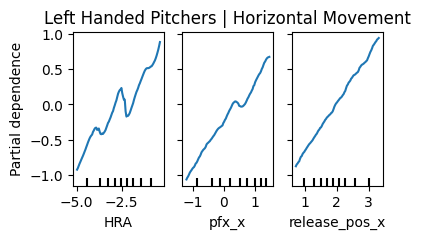

In [37]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Assuming `rf_regressor_h_l` is your trained model for left-handed pitchers
# and `X_train_h_l` is your training data for left-handed pitchers
# Similarly, `rf_regressor_h_r` and `X_train_h_r` are for right-handed pitchers

features_h = ['HRA', 'pfx_x', 'release_pos_x']

# Create and save the partial dependence plot for left-handed pitchers
fig, ax = plt.subplots(figsize=(4, 2))
PartialDependenceDisplay.from_estimator(rf_regressor_h_l, X_train_h_l, features_h, ax=ax)
ax.set_title("Left Handed Pitchers | Horizontal Movement")
plt.savefig("horizontal_location_left_handed.png")






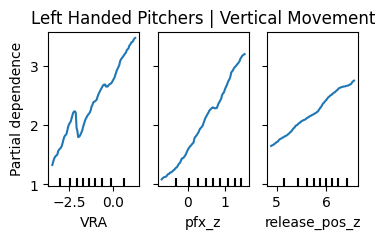

In [36]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay



features_v = ['VRA', 'pfx_z', 'release_pos_z']

# Create and save the partial dependence plot for left-handed pitchers
fig, ax = plt.subplots(figsize=(4, 2))
PartialDependenceDisplay.from_estimator(rf_regressor_v_l, X_train_v_l, features_v, ax=ax)
ax.set_title("Left Handed Pitchers | Vertical Movement")
plt.savefig("horizontal_location_left_handed.png")



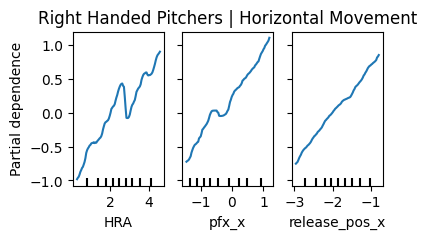

In [38]:
# Create and save the partial dependence plot for right-handed pitchers
fig, ax = plt.subplots(figsize=(4, 2))
PartialDependenceDisplay.from_estimator(rf_regressor_h_r, X_train_h_r, features_h, ax=ax)
ax.set_title("Right Handed Pitchers | Horizontal Movement")
plt.savefig("horizontal_location_right_handed.png")

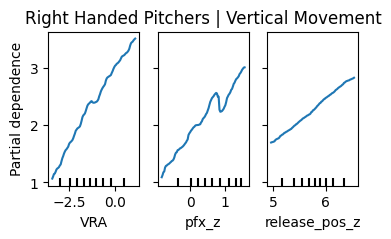

In [39]:
# Create and save the partial dependence plot for right-handed pitchers
fig, ax = plt.subplots(figsize=(4, 2))
PartialDependenceDisplay.from_estimator(rf_regressor_v_r, X_train_v_r, features_v, ax=ax)
ax.set_title("Right Handed Pitchers | Vertical Movement")
plt.savefig("horizontal_location_right_handed.png")